In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
import textblob
import gensim
import spacy
import os

import data
import plot

from chatty.utils import cleaning

Takes a 5 minutes the first time, but use `use_cached` afterward so you don't have to wait in the future.

In [3]:
train, train_vecs, test, test_vecs = data.get_data(use_cached=True)

train['utter_len'] = train['utter'].map(lambda x: len(x.split(' ')))

train['has_question_mark'] = train['utter'].map(lambda x: 1 if'?' in x.split(' ') else 0)
train = pd.concat([train, data.get_lags(train[['has_question_mark']], lag_range=[1])], axis=1)

train['utter_len'] = np.log(train['utter_len'])

Using Cached


In [47]:
LAG_MASK = ['act', 'emo', 'polarity', 'subjectivity']
train_lags = data.get_lags(train[LAG_MASK], lag_range=[1, 2])

Is first utterance?

In [256]:
import spacy

In [240]:
nlp = spacy.load("en")

In [266]:
doc = nlp(cleaning.lower(train['utter'].iloc[100]))

In [270]:
doc[0].dep_

'nsubj'

In [272]:
doc[2].dep_

'nsubj'

In [271]:
doc

i think i going to need some iced water too . is there an extra charge for that ? 

### Classify Dialogue Acts

### First shot Random forest, word vectors, handful of others (need to include POS stuff)

In [213]:
from sklearn.metrics import precision_recall_curve, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer

from chatty.utils import dd_encodings

ACT_MASK = train['act'].notnull() & train['has_question_mark_t-1'].notnull()

assert train['act'][train['act'].notnull()].shape[0] \
      == train_vecs[train['act'].notnull()].shape[0]

TRAIN_MASK = ['first_utterance',
              'subjectivity',
              'utter_len',
              'has_question_mark',
              'has_question_mark_t-1']

X = np.concatenate((train_vecs,
                    train[TRAIN_MASK].values),
                   axis=1)[ACT_MASK]
y = train['act'][ACT_MASK]

In [49]:
results = data.cv_stratified_shuffle(X, y,
                                     RandomForestClassifier(n_jobs=-1),
                                     splits=5)

Training
Training
Training
Training
Training


Normalized confusion matrix
[[0.27979562 0.0947462  0.59246918 0.032989  ]
 [0.04072916 0.39440165 0.38677446 0.17809473]
 [0.05075937 0.05890812 0.87120945 0.01912306]
 [0.00651681 0.06809596 0.05983189 0.86555535]]


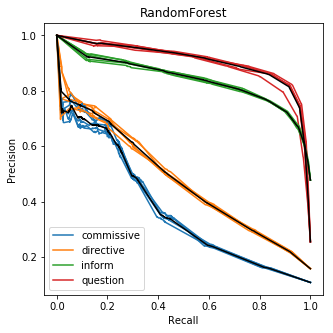

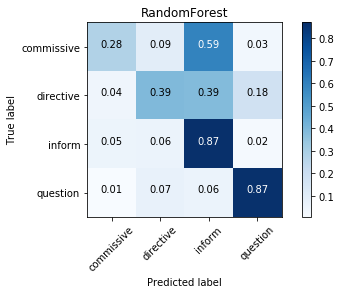

In [9]:
title = "RandomForest"
plot.plot_prec_rec(results, title)
le = LabelEncoder()
le.fit(results['classes'])
cm = confusion_matrix(le.transform(np.concatenate(results['y_true'])),
                      np.argmax(np.concatenate(results['y_proba']), axis=1))
plt.figure()
plot.plot_confusion_matrix(cm, le.classes_, normalize=True, title=title);

### 20 and 21 are duplicates

In [155]:
def class_dist(col, df):
    nums = []
    for i in np.arange(0, 1, .1):
        nums.append(df[df[col] > i].shape[0] / df.shape[0])
    plt.plot(np.arange(0, 1, .1), nums, label=col)
    plt.legend()

def plot_confusion_contour(df):
    for cls in results['classes']:
        class_dist(cls, df)

def make_proba_df(results):
    y_proba = pd.DataFrame(np.concatenate(results['y_proba']))
    y_true = pd.concat(results['y_true'])
    y_proba.index = y_true.index
    y_proba.columns = results['classes']
    return y_proba

df = train.join(make_proba_df(results))

df = df[['utter', 'act'] + list(results['classes'])]

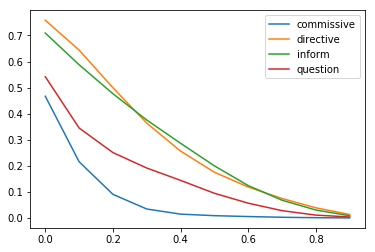

In [156]:
plot_confusion_contour(df[df['act'] == 'directive'])

In [161]:
directive = df[(df['act'] == 'directive')]
directive = directive.sort_values('inform', ascending=False)

### Question marks are very important!

In [173]:
directive['utter'].iloc[:10].map(lambda x: print(x), print('\n'))



 Check , please . 
 I think it is a smart idea . Our boss always likes it when employees take initiatives . 
 I'm afraid we're really staffed this week , Mr . Li . I'd like to meet you , but I'm sorry I really can't . 
 Yeah right ! I ’ m serious ! You should also cut down on your sugar intake as well . You drink carbonated drinks that are high in fructose syrup ! It ’ s really not healthy ! 
 Tiger Woods is about to tee off , and let ’ s see if he has the same luck as Jack . Tiger is asking his caddie for his driver and , he seems to be very nervous . 
 Let me see . 
 OK . how does this sound . let ’ s get you suited up and hit the dance club tonight . I hear that an awesome DJ is playing and there will be a lot of pretty single girls there ! 
 Don ’ t worry about it , I ’ ll call my friend and have him take care of it . I can ’ t believe he was stalking you all these years . What a nut job ! 
 it's an excellent hotel . A friend of mine had her wedding reception there and said it wa

conv     
2730   7     None
11936  5     None
10761  2     None
8521   5     None
8536   4     None
481    3     None
8567   6     None
8580   1     None
8634   8     None
8635   16    None
Name: utter, dtype: object

In [167]:
model = results['models'][0]

In [197]:
features = sorted(zip(model.feature_importances_, [str(i) for i in range(300)] + TRAIN_MASK), key=lambda x: x[0], reverse=True)

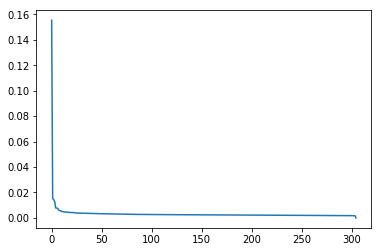

In [200]:
plt.plot(list(zip(*features))[0])

Commissive and Directives are being confused with inform. 

Given the strength of the question mark. 

I think our word vectors are doing very little to help us here. 

I think it's time to introduce some parts of speech tags along with n-grams to capture the use of commissive words and an "I" before them. 

# Didn't work

### Try Bayes with TFIDF (also include POS)

In [208]:
from sklearn.metrics import precision_recall_curve, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.naive_bayes import BernoulliNB

from chatty.utils import dd_encodings

ACT_MASK = train['act'].notnull() & train['has_question_mark_t-1'].notnull()

assert train['act'][train['act'].notnull()].shape[0] \
      == train_vecs[train['act'].notnull()].shape[0]

TRAIN_MASK = ['first_utterance',
              'subjectivity',
              'utter_len',
              'has_question_mark',
              'has_question_mark_t-1']

X = np.concatenate((train_vecs,
                    train[TRAIN_MASK].values),
                   axis=1)[ACT_MASK]
y = train['act'][ACT_MASK]

In [209]:
results = data.cv_stratified_shuffle(X, y,
                                     BernoulliNB(),
                                     splits=5)

Training
Training
Training
Training
Training


Normalized confusion matrix
[[0.32078196 0.29223592 0.33644341 0.05053871]
 [0.06117001 0.62748837 0.18587446 0.12546716]
 [0.16857561 0.22105051 0.56614865 0.04422524]
 [0.03962032 0.18398187 0.11144692 0.66495089]]


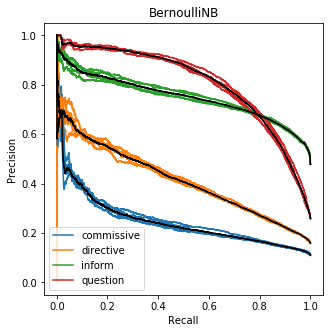

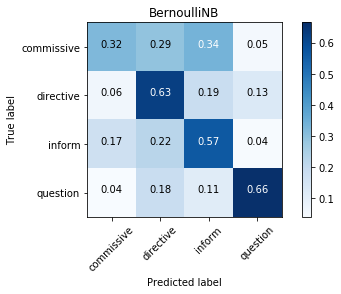

In [210]:
title = "BernoulliNB"
plot.plot_prec_rec(results, title)
le = LabelEncoder()
le.fit(results['classes'])
cm = confusion_matrix(le.transform(np.concatenate(results['y_true'])),
                      np.argmax(np.concatenate(results['y_proba']), axis=1))
plt.figure()
plot.plot_confusion_matrix(cm, le.classes_, normalize=True, title=title);